# PCA with Cultural Diffusion

In [24]:
import numpy as np
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation as LDA
from sklearn.manifold import TSNE
from collections import defaultdict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
with open('../data/cooking_data.json', 'r') as f:
    data = json.load(f)

In [3]:
print(data[0])

{'ingredients': ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles'], 'id': 10259, 'cuisine': 'greek'}


In [29]:
def json_to_data(json):
    cuisine_ingred = defaultdict(set)
    cuisines = set()
    ingredients = set()
    for record in json:
        cuisine = record['cuisine']
        record_ingred = record['ingredients']
        cuisines.add(cuisine)
        cuisine_ingred[cuisine].update(record_ingred)
        ingredients.update(record_ingred)
    cuisine_ingred = {key: list(val) for key, val in cuisine_ingred.items()}
    cuisines = list(cuisines)
    ingredients = list(ingredients)
    return cuisines, ingredients, cuisine_ingred


def build_count_matrix(cuisines, ingredients, cuisine_ingred):
    count_matrix = np.zeros((len(cuisines), len(ingredients)))
    ingredients = {ingredients[i]: i for i in range(len(ingredients))}
    i = 0
    for cuisine in cuisines:
        curr_ingreds = cuisine_ingred[cuisine]
        for ingred in curr_ingreds:
            j = ingredients[ingred]
            count_matrix[i, j] += 1
        i += 1
    return count_matrix


def matrix_to_tf_idf(matrix):
    return TfidfTransformer().fit_transform(matrix).toarray()


def build_pca(matrix):
    return PCA(n_components=2).fit_transform(matrix)

def build_lda(matrix):
    return LDA(n_topics=2).fit_transform(matrix)

def build_tsne(matrix):
    return TSNE(n_components=2).fit_transform(matrix)

def build_clusters(matrix, n_clusters=3):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    return kmeans.fit(matrix).predict(matrix)


def count_jaccard_dist(cuisine_ingred, labels):
    effect = np.zeros((len(labels)))
    unions = [set() for i in range(len(labels))]
    for i, values in enumerate(cuisine_ingred.values()):
        unions[labels[i]].update(values)
    unions = list(map(len, unions))
    for i, values in enumerate(cuisine_ingred.values()):
        effect[i] = len(values) / unions[labels[i]]
    return effect


def plot_clusters(coords, cuisines, labels, area):
    plt.figure(1, (20, 15))
    x, y, text = [], [], []
    for i in range(len(coords)):
        x.append(coords[i][0])
        y.append(coords[i][1])
        plt.text(coords[i][0], coords[i][1], cuisines[i], size=25,
                horizontalalignment='center')
    plt.axis('off')
    plt.xlabel('coord1')
    plt.ylabel('coord2')
    plt.scatter(x, y, c=labels, s=area, alpha=0.4, edgecolors='b', linewidths=2)
    plt.show()

In [9]:
n_clusters = 5
cuisines, ingredients, cuisine_ingred = json_to_data(data)
count_matrix = build_count_matrix(cuisines, ingredients, cuisine_ingred)
tfidf_matrix = matrix_to_tf_idf(count_matrix)

## PCA gives best results

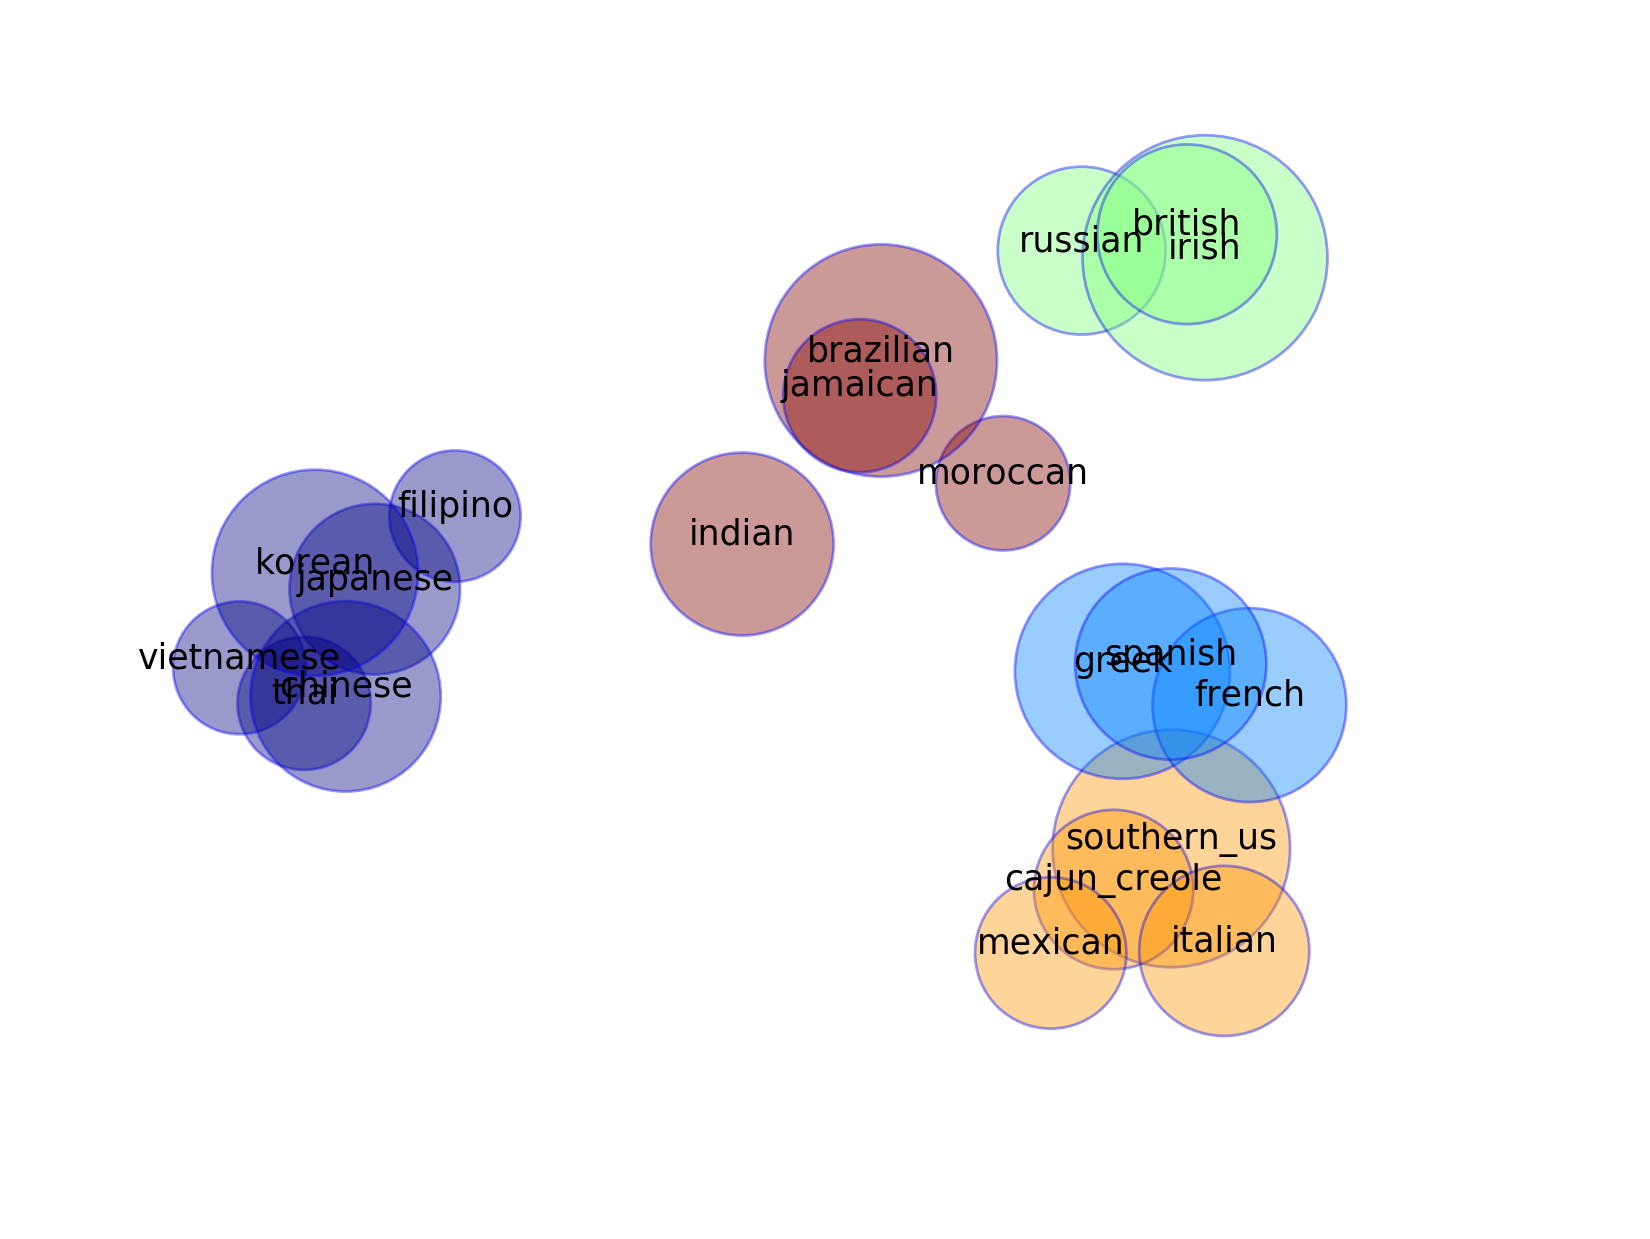

In [17]:
pca_coords = build_pca(tfidf_matrix)
pca_labels = build_clusters(pca_coords, n_clusters)
pca_jaccard_dist = count_jaccard_dist(cuisine_ingred, pca_labels)
plot_clusters(pca_coords, cuisines, pca_labels, list(map(lambda it: it*40000, pca_jaccard_dist)))

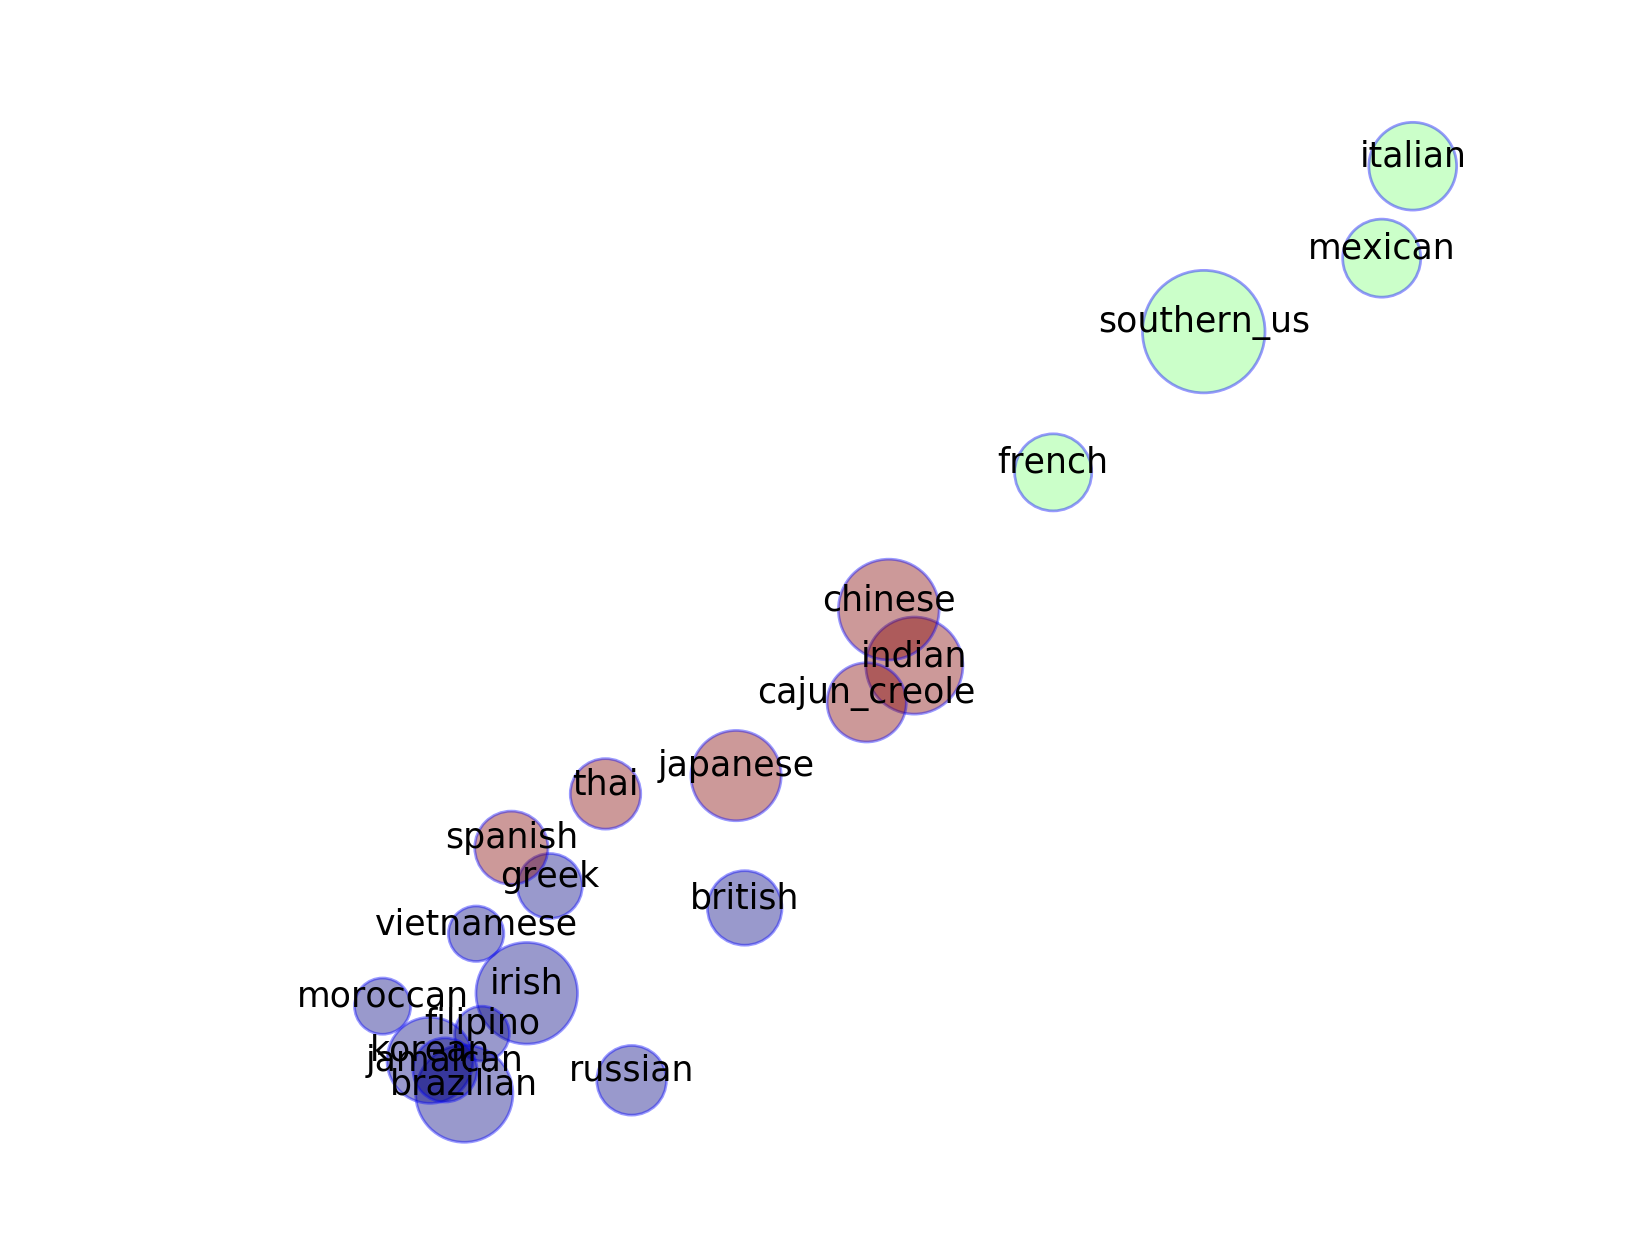

In [26]:
lda_coords = build_lda(tfidf_matrix)
lda_labels = build_clusters(lda_coords, 3)
lda_jaccard_dist = count_jaccard_dist(cuisine_ingred, lda_labels)
plot_clusters(lda_coords, cuisines, lda_labels, list(map(lambda it: it*10000, lda_jaccard_dist)))

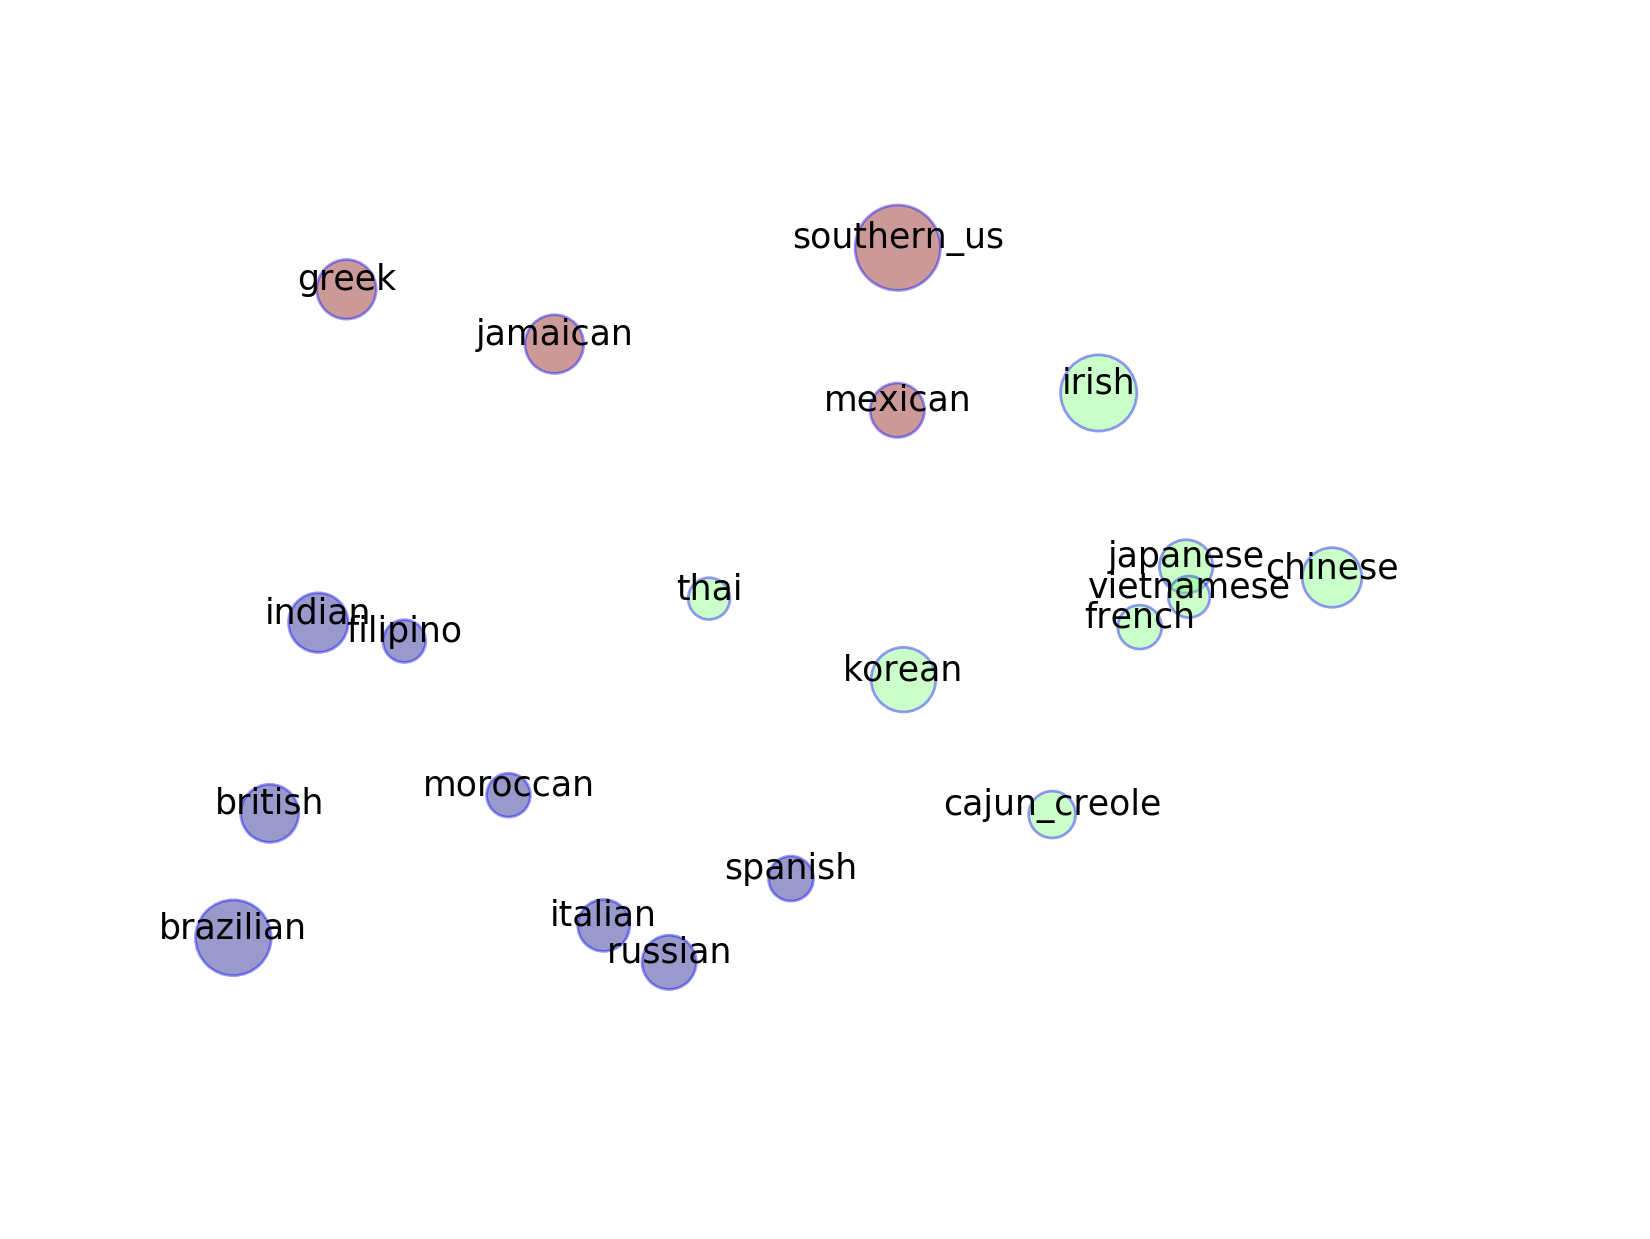

In [42]:
tsne_coords = build_tsne(tfidf_matrix)
tsne_coords = list(map(lambda it: [it[0] * 5000, it[1] * 5000], tsne_coords))
tsne_labels = build_clusters(tsne_coords, n_clusters=3)
tsne_jaccard_dist = count_jaccard_dist(cuisine_ingred, tsne_labels)
plot_clusters(tsne_coords, cuisines, tsne_labels, list(map(lambda it: it*5000, tsne_jaccard_dist)))